#Hair Type Detection
### Realisé par : EL-BIYAALI NOUHAYLA & EL ASRI AHLAM

La détection du type de cheveux est une tâche essentielle dans plusieurs domaines, notamment la cosmétique, la coiffure et la mode. Grâce aux avancées en intelligence artificielle et en vision par ordinateur, il est désormais possible d'automatiser cette classification avec un haut niveau de précision. Ce projet vise à développer un modèle basé sur MobileNetV2 pour classifier les types de cheveux en cinq catégories : Straight (lisses), Wavy (ondulés), Curly (bouclés), Dreadlocks, et Kinky (crépus).

# 📂 1. Chargement des bibliothèques et des données



In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copy2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

In [ ]:
# Montage de Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chemin vers les données
data_dir = '/content/drive/MyDrive/archive/data'
classes = os.listdir(data_dir)
print(classes)

['Wavy', 'curly', 'dreadlocks', 'Straight', 'kinky']


# 🖼️ 2. Visualisation de quelques images

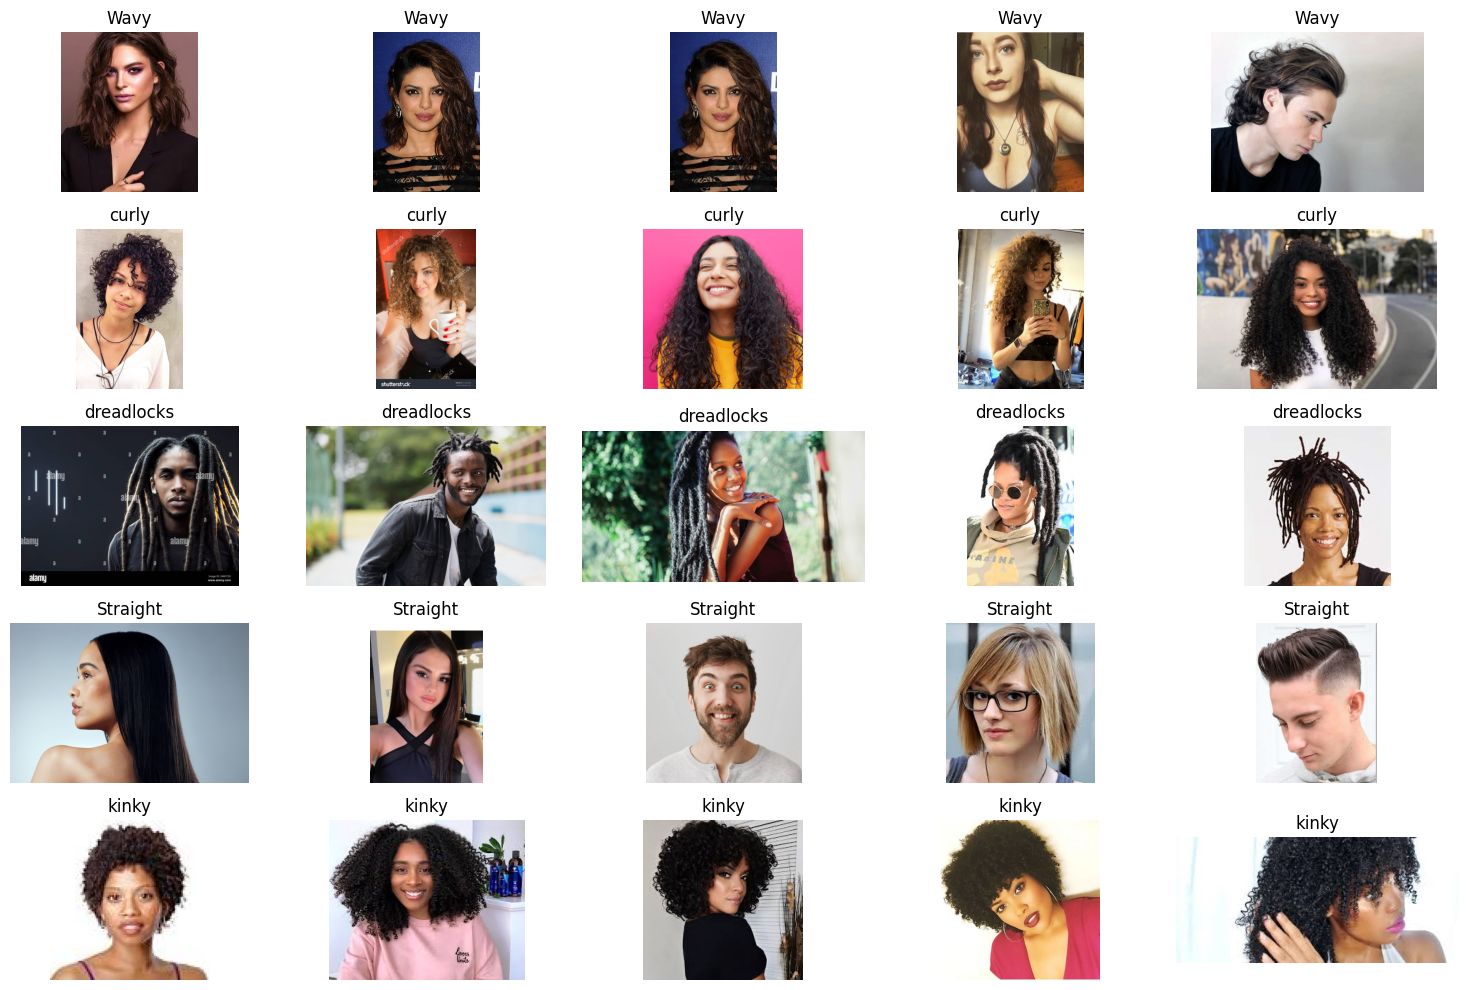

In [ ]:
# Classes
classes = os.listdir(data_dir)

# Visualiser quelques images de chaque classe
def visualize_images(data_dir, classes):
    fig, axes = plt.subplots(len(classes), 5, figsize=(15, 10))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(data_dir, cls)
        images = os.listdir(cls_path)[:5]  # Prendre 5 images de chaque classe
        for j, img_name in enumerate(images):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()

visualize_images(data_dir, classes)

# 🏗️ 3. Prétraitement des images

In [ ]:
# Générateur d'images avec normalisation
datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
# Chargement des images et normalisation
data_dir = '/content/drive/MyDrive/archive/data'

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Redimensionner les images à 224x224 pixels
    batch_size=32,           # Charger les images par lots de 32 (utile pour l'entraînement)
    class_mode='categorical' # Type de labels : 'categorical' pour une classification multi-classes
)

Found 1985 images belonging to 5 classes.


In [ ]:
# Vérifier la structure des données chargées
for data_batch, label_batch in train_generator:
    print(f"Batch de données (images) : {data_batch.shape}")
    print(f"Batch de labels : {label_batch.shape}")
    break

Batch de données (images) : (32, 224, 224, 3)
Batch de labels : (32, 5)


# 🎨 4. Data Augmentation et Équilibrage des classes

In [ ]:
data_augmentation_dir = '/content/drive/MyDrive/archive/data_augmentation'

# Calcul du nombre d'images par classe
class_counts = {class_name: len(os.listdir(os.path.join(data_dir, class_name)))
                for class_name in os.listdir(data_dir)}

# Trouver le nombre d'images cible (le maximum des classes)
max_count = max(class_counts.values())

# Générateur de Data Augmentation
datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Créer des répertoires pour les données équilibrées
os.makedirs(data_augmentation_dir, exist_ok=True)
for class_name in class_counts:
    os.makedirs(os.path.join(data_augmentation_dir, class_name), exist_ok=True)

# Traiter chaque classe pour équilibrer
for class_name, count in class_counts.items():
    class_path = os.path.join(data_dir, class_name)
    output_class_path = os.path.join(data_augmentation_dir, class_name)

    # Copier toutes les images existantes dans le répertoire de sortie
    for img_file in os.listdir(class_path):
        copy2(os.path.join(class_path, img_file), output_class_path)

    # Calculer combien d'images supplémentaires sont nécessaires
    num_to_generate = max_count - count

    # Appliquer la Data Augmentation pour compléter la classe
    img_files = os.listdir(class_path)
    for i in range(num_to_generate):
        img_file = img_files[i % len(img_files)]
        img_path = os.path.join(class_path, img_file)
        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        # Générer une image augmentée (Une seule image par itération)
        for batch in datagen_aug.flow(img_array, batch_size=1,
                                      save_to_dir=output_class_path,
                                      save_prefix='aug',
                                      save_format='jpg'):
            break

In [ ]:
# Compter le nombre d'images dans chaque classe
class_counts_after_augmentation = {
    class_name: len(os.listdir(os.path.join(data_augmentation_dir, class_name)))
    for class_name in os.listdir(data_augmentation_dir)
}

# Afficher le nombre d'images par classe
for class_name, count in class_counts_after_augmentation.items():
    print(f"Classe '{class_name}': {count} images")

Classe 'Wavy': 511 images
Classe 'curly': 514 images
Classe 'dreadlocks': 514 images
Classe 'Straight': 514 images
Classe 'kinky': 509 images


# 🔄 5. Conversion des images en format JPG

In [ ]:
data_converted_dir = '/content/drive/MyDrive/archive/data_converted'  # Répertoire après conversion
os.makedirs(data_converted_dir, exist_ok=True)

# Parcourir chaque classe
for class_name in os.listdir(data_augmentation_dir):
    class_path = os.path.join(data_augmentation_dir, class_name)
    output_class_path = os.path.join(data_converted_dir, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    # Parcourir chaque fichier dans la classe
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        output_img_path = os.path.join(output_class_path, os.path.splitext(img_file)[0] + '.jpg')  # Nom de sortie en .jpg

        try:
            # Ouvrir l'image et la convertir en RGB (éviter les erreurs avec PNG ou autres formats)
            img = Image.open(img_path).convert('RGB')
            # Sauvegarder au format .jpg
            img.save(output_img_path, 'JPEG')
        except Exception as e:
            print(f"Erreur lors de la conversion de l'image {img_path}: {e}")

In [ ]:
# Initialiser les variables pour le comptage
total_files = 0
jpg_files = 0

# Parcourir chaque classe
for class_name in os.listdir(data_converted_dir):
    class_path = os.path.join(data_converted_dir, class_name)

    # Parcourir chaque fichier dans la classe
    for img_file in os.listdir(class_path):
        total_files += 1
        if img_file.lower().endswith('.jpg'):
            jpg_files += 1

# Vérifier si tous les fichiers sont au format .jpg
if total_files == jpg_files:
    print(f"Toutes les {total_files} images sont bien au format .jpg.")
else:
    print(f"Problème détecté : {jpg_files} fichiers sont en .jpg sur un total de {total_files} fichiers.")

Toutes les 2541 images sont bien au format .jpg.


In [ ]:
# Compter le nombre d'images dans chaque classe
class_counts_after_conversion = {
    class_name: len(os.listdir(os.path.join(data_converted_dir, class_name)))
    for class_name in os.listdir(data_converted_dir)
}

# Afficher le nombre d'images par classe
for class_name, count in class_counts_after_conversion.items():
    print(f"Classe '{class_name}': {count} images")

Classe 'Wavy': 503 images
Classe 'curly': 505 images
Classe 'dreadlocks': 511 images
Classe 'Straight': 514 images
Classe 'kinky': 508 images


# 🔀 6. Division des données en Train, Validation et Test

In [ ]:
data_split_dir = '/content/drive/MyDrive/archive/data_split'
os.makedirs(data_split_dir, exist_ok=True)

# Créer les sous-dossiers pour train, val et test
for subset in ['train', 'val', 'test']:
    for class_name in os.listdir(data_converted_dir):
        os.makedirs(os.path.join(data_split_dir, subset, class_name), exist_ok=True)

# Répartition des données
for class_name in os.listdir(data_converted_dir):
    class_path = os.path.join(data_converted_dir, class_name)
    images = os.listdir(class_path)

    # 80% train, 20% restant
    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
    # 10% validation, 10% test
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Copier les fichiers dans les dossiers correspondants
    for img_file in train_images:
        shutil.copy(os.path.join(class_path, img_file), os.path.join(data_split_dir, 'train', class_name))
    for img_file in val_images:
        shutil.copy(os.path.join(class_path, img_file), os.path.join(data_split_dir, 'val', class_name))
    for img_file in test_images:
        shutil.copy(os.path.join(class_path, img_file), os.path.join(data_split_dir, 'test',class_name))

In [ ]:
train_dir = '/content/drive/MyDrive/archive/data_split/train'
val_dir = '/content/drive/MyDrive/archive/data_split/val'
test_dir = '/content/drive/MyDrive/archive/data_split/test'

# Générateur pour normalisation
datagen = ImageDataGenerator(rescale=1./255)

# Appliquer batch_size=8 pour tous les générateurs
batch_size = 8

# Générateur d'entraînement
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Toujours mélanger les données d'entraînement
)

# Générateur de validation
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Pas besoin de mélanger la validation
)

# Générateur de test
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # On garde les images fixes pour tester
)


Found 2034 images belonging to 5 classes.
Found 253 images belonging to 5 classes.
Found 256 images belonging to 5 classes.


# 🏗️ 7. Construction du Modèle MobileNetV2


In [ ]:
# MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-Tuning (dégeler certaines couches)
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.6),  # Augmenter à 60% pour éviter le surapprentissage
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # Régularisation L2
    Dropout(0.5),  # Plus de dropout entre les couches
    Dense(5, activation='softmax')
])


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Réduction du LR de 50% si la validation loss ne s’améliore pas
    patience=3,  # Attend 3 epochs sans amélioration avant de réduire
    min_lr=1e-6  # Ne descend pas en dessous de 0.000001
)

optimizer = RMSprop(learning_rate=0.0001)  # On garde un LR bas pour éviter la divergence

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# 🚀 8. Entraînement du Modèle

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


255/255 ━━━━━━━━━━━━━━━━━━━━ 897s 3s/step - accuracy: 0.3041 - loss: 5.0237 - val_accuracy: 0.6601 - val_loss: 3.5210 - learning_rate: 1.0000e-04
Epoch 2/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.6385 - loss: 3.4719 - val_accuracy: 0.7510 - val_loss: 3.4002 - learning_rate: 1.0000e-04
Epoch 3/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.7138 - loss: 3.1032 - val_accuracy: 0.7866 - val_loss: 3.0624 - learning_rate: 1.0000e-04
Epoch 4/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.7674 - loss: 2.8052 - val_accuracy: 0.8261 - val_loss: 2.8087 - learning_rate: 1.0000e-04
Epoch 5/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.8133 - loss: 2.5166 - val_accuracy: 0.8696 - val_loss: 2.5362 - learning_rate: 1.0000e-04
Epoch 6/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.8215 - loss: 2.4317 - val_accuracy: 0.8735 - val_loss: 2.3712 - learning_rate: 1.0000e-04
Epoch 7/30
255/255 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy

* L'entraînement du modèle se déroule sur 30 epochs, avec une optimisation progressive des performances. Au début, la précision sur l'ensemble d'entraînement est faible (30.41 %), mais elle augmente rapidement au fil des itérations. Dès la cinquième époque, le modèle atteint plus de 80 % de précision sur l'entraînement et environ 87 % sur la validation, indiquant une bonne généralisation. La perte diminue également de manière significative, ce qui montre que le modèle apprend efficacement à différencier les classes. À partir de l'époque 20, la précision dépasse 97 %, et le learning rate est réduit à 5e-5 pour affiner l’apprentissage et stabiliser les performances.

* La précision d'entraînement atteint 99.32 %, tandis que celle de validation est plus basse à 88.93 %, ce qui suggère un léger sur-apprentissage. En effet, l'écart entre l'entraînement et la validation (environ 10%) indique que le modèle s'est trop ajusté aux données d'entraînement et pourrait ne pas généraliser parfaitement à des données nouvelles.


# 📊 9. Évaluation et Prédiction


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.9175 - loss: 0.4768
Test Accuracy: 91.02%



* La précision du test (91.02%) est légèrement meilleure que celle de la validation (88.93%), ce qui est un bon signe. Cela signifie que le modèle fonctionne bien sur des données jamais vues auparavant.

* La perte en validation (0.4190) et en test (0.4768) sont relativement proches, confirmant que le modèle n'a pas subi de sur-ajustement extrême et garde une bonne capacité de prédiction.

**Conclusion:**
* Le modèle est bien entraîné et affiche une performance solide sur le test final.
* Un léger sur-apprentissage est visible, mais il reste maîtrisé.
* Pour améliorer encore le modèle, on pourrait augmenter la régularisation (Dropout, L2) ou ajouter des données d'entraînement pour mieux généraliser.
* En l’état actuel, ce modèle est très performant et fiable à plus de 91 % sur de nouvelles données.

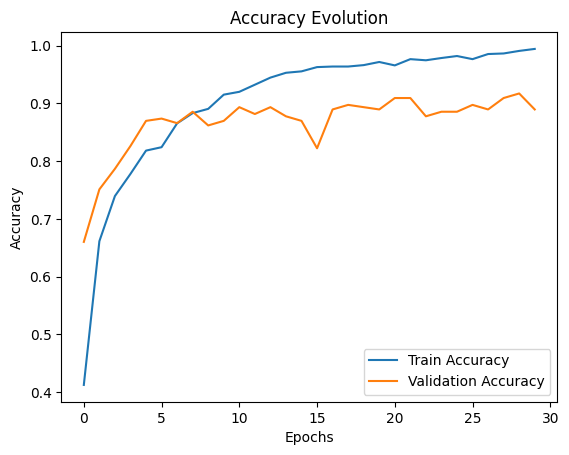

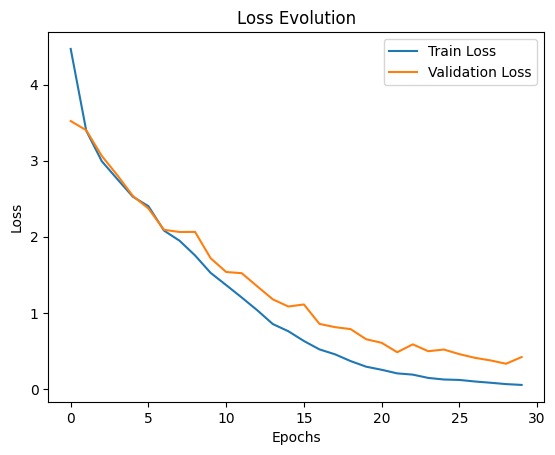

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')
plt.show()


**Accuracy Evolution:**
* La courbe Train Accuracy (en bleu) montre une augmentation constante de la précision, atteignant près de 99% à la fin de l'entraînement.
* La courbe Validation Accuracy (en orange) suit également une tendance positive, mais elle fluctue légèrement après l’epoch 10 et se stabilise autour de 89-91%.
* On observe une séparation progressive entre les deux courbes après environ 15 epochs, indiquant un léger sur-apprentissage.

**Loss Evolution:**
* La courbe Train Loss (en bleu) diminue régulièrement, atteignant une valeur proche de 0, ce qui est attendu pour un modèle bien entraîné.
* La courbe Validation Loss (en orange) diminue également, mais elle cesse de baisser après 20 epochs et commence à fluctuer légèrement.

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step


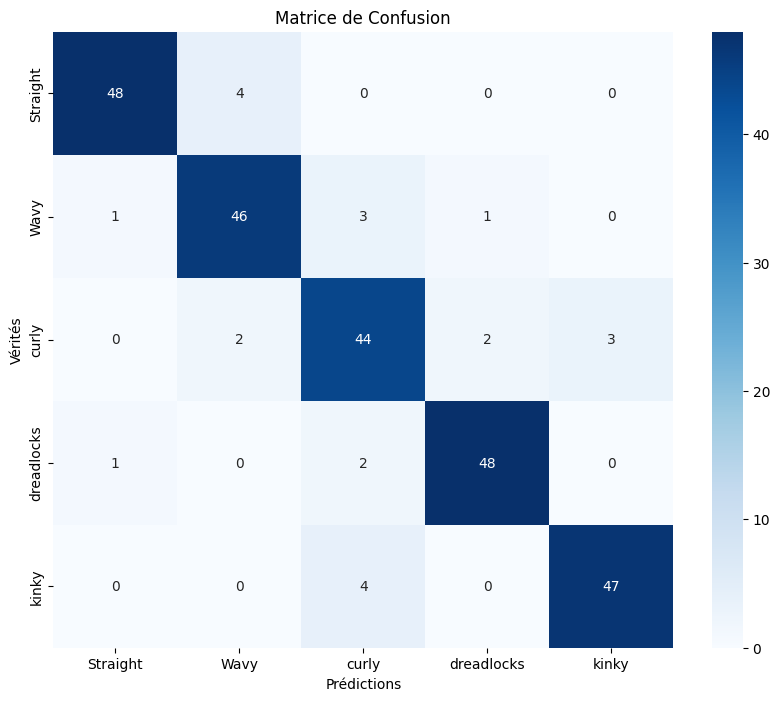

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        52
           1       0.88      0.90      0.89        51
           2       0.83      0.86      0.85        51
           3       0.94      0.94      0.94        51
           4       0.94      0.92      0.93        51

    accuracy                           0.91       256
   macro avg       0.91      0.91      0.91       256
weighted avg       0.91      0.91      0.91       256



In [ ]:
# Matrice de confusion : Identifier quelles classes sont correctement ou mal classées
# Prédictions sur le jeu de test
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)
y_true = test_generator.classes

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()

# Rapport de classification
print(classification_report(y_true, y_pred_classes))

La matrice de confusion montre que les classes "Straight" et "Dreadlocks" sont particulièrement bien reconnues, avec 48 prédictions correctes sur 52 et 48 sur 51, respectivement. Toutefois, on observe une certaine confusion entre les classes "Curly" et "Kinky", avec 4 échantillons de "Kinky" classés comme "Curly", et 3 erreurs inverses. Cela se reflète également dans le rapport de classification, où la classe "Curly" obtient la plus faible précision (83%) et le plus faible F1-score (85%), indiquant une difficulté du modèle à bien différencier ces textures capillaires.

Malgré ces quelques erreurs, le rappel est relativement équilibré sur toutes les classes, ce qui signifie que le modèle ne favorise pas une catégorie en particulier. De plus, la valeur élevée des F1-scores (toutes supérieures à 85%) montre que le modèle réussit globalement à faire la distinction entre les différentes classes de cheveux. Pour améliorer les résultats, il serait pertinent d'ajouter des données pour les classes les plus confondues, de renforcer la data augmentation.

In [ ]:
 # Courbes ROC et F1-score : Afficher les métriques globales pour chaque classe
# Calcul du F1-score
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f'F1-score (moyenne pondérée): {f1:.2f}')

F1-score (moyenne pondérée): 0.90


# 💾 10. Sauvegarde et Prédiction sur de nouvelles images


In [ ]:
#Sauvegarder le modèle pour l'utiliser ultérieurement
model.save('/content/drive/MyDrive/model_mobilenet.h5')

In [ ]:
print(train_generator.class_indices)
print(class_names)

{'Straight': 0, 'Wavy': 1, 'curly': 2, 'dreadlocks': 3, 'kinky': 4}
['Straight', 'Wavy', 'Curly', 'Dreadlocks', 'Kinky']


Modèle chargé avec succès !
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


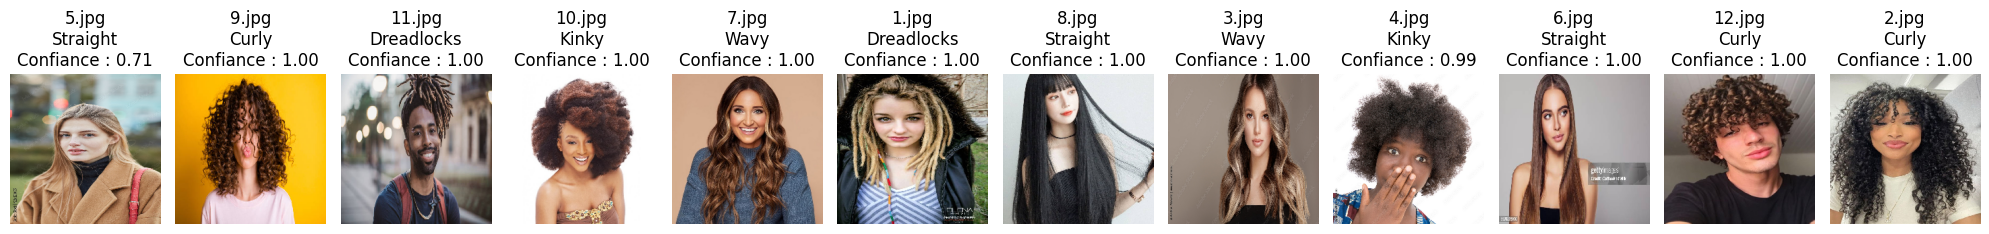

In [ ]:
# Prédiction sur des nouvelles images


# Charger le modèle entraîné
model_path = "/content/drive/MyDrive/model_mobilenet.h5"  # Remplacez par le chemin de votre modèle
model = load_model(model_path)
print("Modèle chargé avec succès !")

# Liste des classes dans l'ordre correspondant à l'entraînement
class_names = ['Straight', 'Wavy', 'Curly', 'Dreadlocks', 'Kinky']

# Fonction pour prédire sur une seule image
def predict_single_image(model, img_path, class_names):
    img_size = (224, 224)  # Taille d'entrée pour MobileNet
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Normalisation des pixels entre 0 et 1
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension batch
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)  # Index de la classe prédite
    confidence = np.max(prediction)  # Confiance associée à la classe prédite
    class_name = class_names[class_index]  # Nom de la classe prédite
    return class_name, confidence

# Fonction pour prédire sur plusieurs images dans un dossier
def predict_multiple_images(model, folder_path, class_names):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    fig, axes = plt.subplots(1, len(image_files), figsize=(20, 5))

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(folder_path, img_name)
        class_name, confidence = predict_single_image(model, img_path, class_names)

        img = load_img(img_path, target_size=(224, 224))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{img_name}\n{class_name}\nConfiance : {confidence:.2f}")

    plt.tight_layout()
    plt.show()

# Chemin vers le dossier contenant les images à tester
test_image_dir = "/content/drive/MyDrive/archive/test projet/test projet"

# Prédire sur toutes les images du dossier
predict_multiple_images(model, test_image_dir, class_names)

Le modèle fonctionne très bien avec des prédictions fiables et précises. Il montre un haut niveau de confiance sur la majorité des images, confirmant la qualité de l'entraînement. Toutefois, quelques images affichent une confiance plus faible, indiquant des cas potentiels d’amélioration via un affinement des données d'entraînement.


**Conclusion:**
Les résultats obtenus montrent que le modèle MobileNetV2 offre une précision élevée (91 %) sur l'ensemble de test, avec des prédictions fiables sur la majorité des images. La matrice de confusion et les métriques de classification révèlent une bonne distinction entre les catégories, bien que certaines classes proches, comme Curly et Kinky, présentent quelques confusions.

Malgré ces performances satisfaisantes, des améliorations sont envisageables, notamment par l'ajout de données supplémentaires, une meilleure augmentation des données,